In [ ]:
import pandas as pandas
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
def create_folders():
    base_folder = "/content/augmented_data"
    sub_folders = ["yes", "no"]

    # Create base folder if it doesn't exist
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)

    # Create sub-folders inside base folder
    for folder in sub_folders:
        folder_path = os.path.join(base_folder, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

    print("Folders created successfully in Colab workspace!")

create_folders()

Folders created successfully in Colab workspace!


In [ ]:
#Dataset
import zipfile
z=zipfile.ZipFile('archive.zip')
z.extractall()

In [ ]:
folder = 'archive/brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [ ]:
folder = 'archive/brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" +str(count)+".jpg"
    os.rename(source, destination)
    count+=1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


#EDA (Exploratory Data Analysis)

In [ ]:
listyes = os.listdir("archive/brain_tumor_dataset/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("archive/brain_tumor_dataset/no/")
number_files_no = len(listno)
print(number_files_no)

155
98


#plot

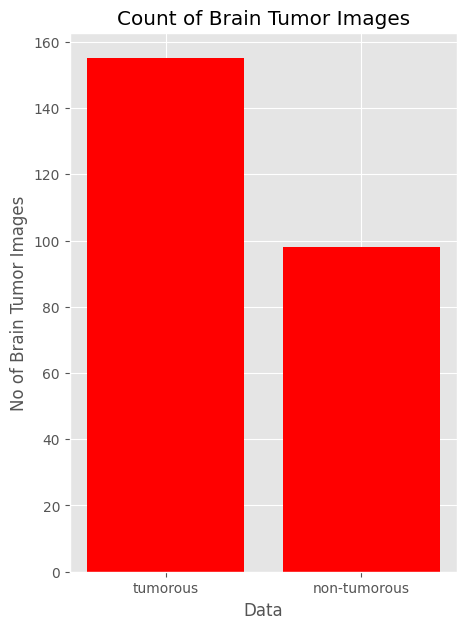

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

#Data Augmentation
#155(61%),98(39%)
#imbalance

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [ ]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [ ]:
import time
start_time = time.time()

yes_path = 'archive/brain_tumor_dataset/yes'
no_path = 'archive/brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:51.00323009490967


In [ ]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")


In [ ]:
data_summary(augmented_data_path)

Number of sample: 2064
1084 Number of positive sample in percentage: 52.51937984496124%
980 Number of negative sample in percentage: 47.48062015503876%


In [ ]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1084
980


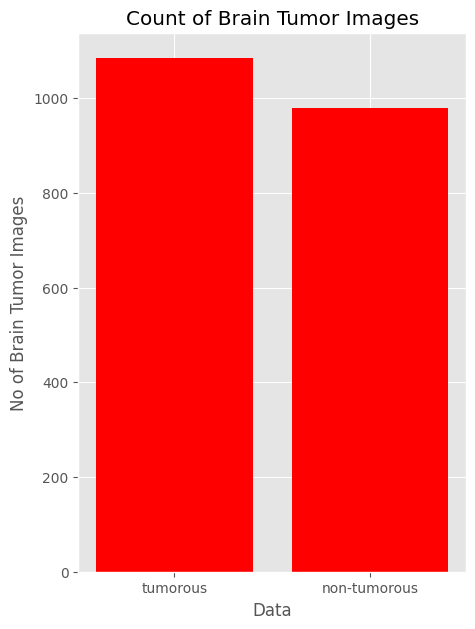

In [ ]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# Data Preprocessing

# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [ ]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

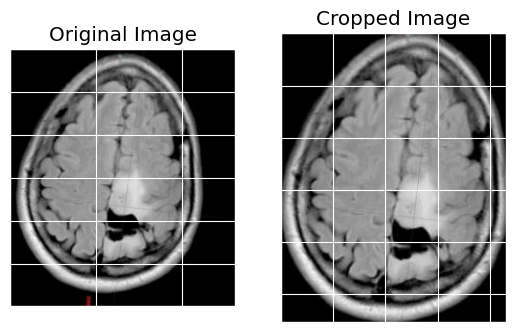

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
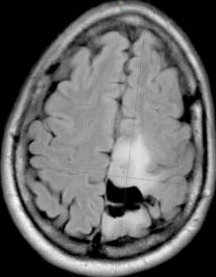

In [ ]:
img = cv2.imread('augmented_data/yes/aug_Y_100_0_2715.jpg')
crop_brain_tumor(img, True)

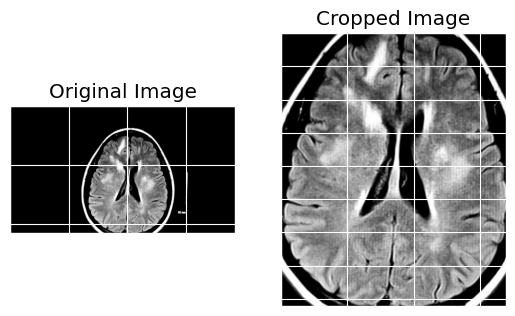

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
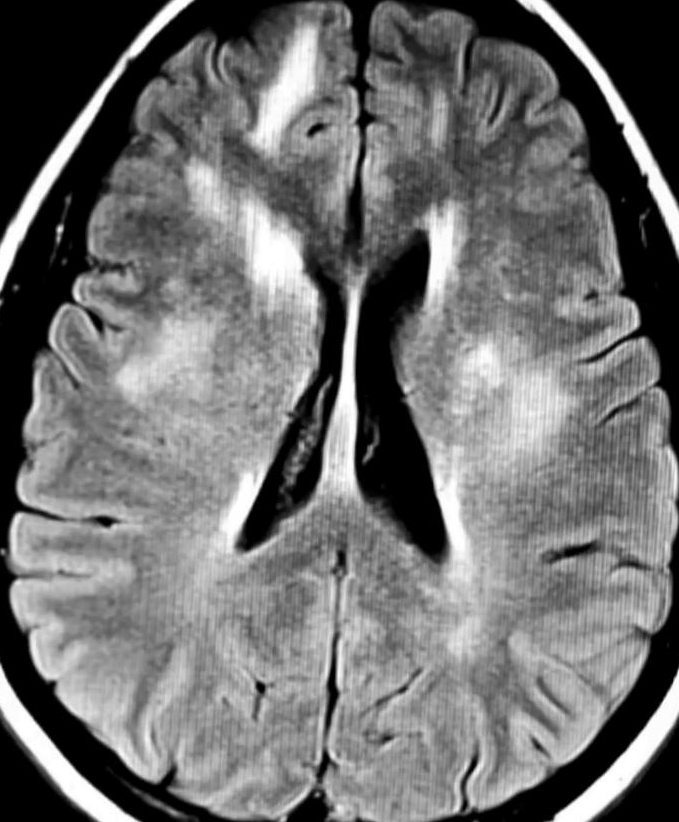

In [ ]:
img = cv2.imread('augmented_data/no/aug_N_11_0_5690.jpg')
crop_brain_tumor(img, True)

In [ ]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

# image loading

In [ ]:
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    X = []
    y = []

    image_width, image_height = image_size

    # Loop through each directory (yes/no categories)
    for directory in dir_list:
        for filename in os.listdir(directory):
            # Build the full file path
            file_path = os.path.join(directory, filename)

            # Read the image
            image = cv2.imread(file_path)
            if image is None:
                continue  # Skip if the image failed to load

            # Apply preprocessing (assuming crop_brain_tumor is defined)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0  # Normalize pixel values to [0, 1]

            # Append the image and label
            X.append(image)
            label = 1 if directory.endswith("yes") else 0
            y.append(label)

    # Convert lists to NumPy arrays with the correct data types
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    # Shuffle data
    X, y = shuffle(X, y)

    print(f"Number of examples: {len(X)}")
    print(f"X shape: {X.shape}, data type: {X.dtype}")
    print(f"y shape: {y.shape}, data type: {y.dtype}")

    return X, y


def load_data_in_batches(dir_list, image_size, batch_size):
    batch_X, batch_y = [], []
    image_width, image_height = image_size

    # Loop through each directory (yes/no categories)
    for directory in dir_list:
        for filename in os.listdir(directory):
            # Build the full file path
            file_path = os.path.join(directory, filename)

            # Read the image
            image = cv2.imread(file_path)
            if image is None:
                continue  # Skip if the image failed to load

            # Apply preprocessing (assuming crop_brain_tumor is defined)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0  # Normalize pixel values to [0, 1]

            batch_X.append(image)
            label = 1 if directory.endswith("yes") else 0
            batch_y.append(label)

            # Yield the batch when it's full
            if len(batch_X) == batch_size:
                yield np.array(batch_X, dtype=np.float32), np.array(batch_y, dtype=np.int32)
                batch_X, batch_y = [], []

    # Yield any remaining data after finishing the loop
    if batch_X:
        yield np.array(batch_X, dtype=np.float32), np.array(batch_y, dtype=np.int32)


# Example usage
augmented_path = 'augmented_data/'
augmented_yes = os.path.join(augmented_path, 'yes')
augmented_no = os.path.join(augmented_path, 'no')

IMAGE_WIDTH, IMAGE_HEIGHT = (120, 120)

# Load data
X, y = load_data([augmented_yes, augmented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of examples: 2064
X shape: (2064, 120, 120, 3), data type: float32
y shape: (2064,), data type: int32


In [ ]:

def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
plot_sample_images(X,y)

Output hidden; open in https://colab.research.google.com to view.

# Data Spliting
# Train
# Test
# Validation

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [ ]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [ ]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(922,1084):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

# 80% 10% 10%

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833,979):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

# Model Buliding

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 1445 images belonging to 2 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 310 images belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 308 images belonging to 2 classes.


In [ ]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [ ]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [ ]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# callback
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history_01 = model_01.fit(
    train_generator,
    steps_per_epoch=45,              # Based on batch_size and total samples
    epochs=25,                       # You can increase this based on your needs
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[es, cp, lrr]
)

Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.6394 - loss: 0.6195
Epoch 1: val_loss did not improve from 0.41013
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 712ms/step - accuracy: 0.6396 - loss: 0.6195 - val_accuracy: 0.7435 - val_loss: 0.5543 - learning_rate: 1.0000e-04
Epoch 2/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.6562 - loss: 0.6242
Epoch 2: val_loss did not improve from 0.41013
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.6562 - loss: 0.6242 - val_accuracy: 0.7273 - val_loss: 0.5694 - learning_rate: 1.0000e-04
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.7071 - loss: 0.5856
Epoch 3: val_loss did not improve from 0.41013
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 667ms/step - accuracy: 0.7067 - loss: 0.5856 - val_accuracy: 0.7143 - val_loss: 0.5478 - learning_rate: 1.0000e-04
Epoch 4/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.7500 - loss: 0.5295
Epoch 4: val_loss did not improve from 0.41013
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 1

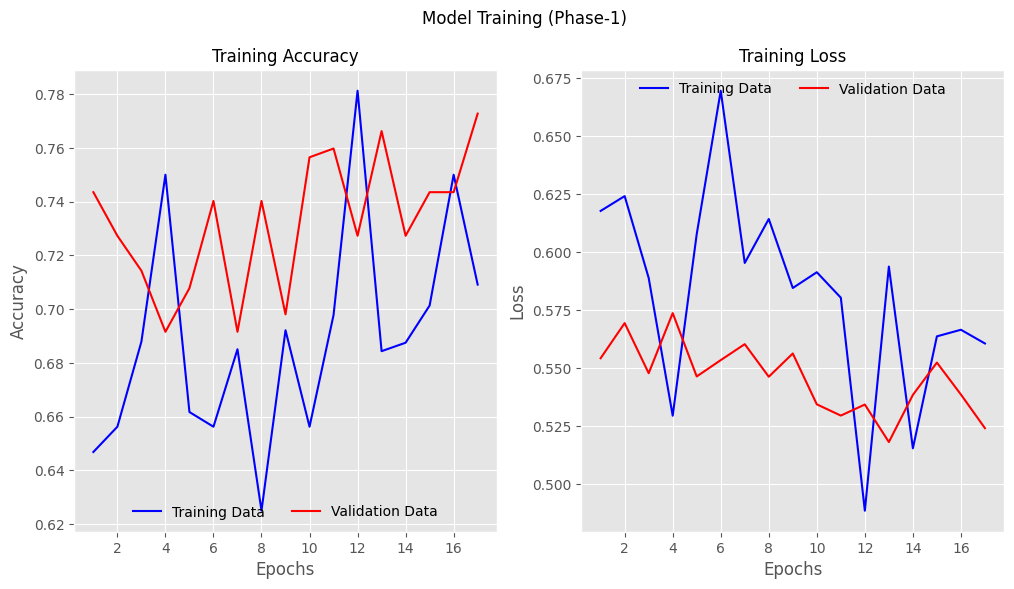

In [ ]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Phase-1)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [ ]:
model_01.load_weights("model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - accuracy: 0.7162 - loss: 0.5585
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 588ms/step - accuracy: 0.6702 - loss: 0.5705


In [ ]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.5317562818527222
Validation Acc: 0.7402597665786743
Testing Loss: 0.5550336241722107
Testing Acc: 0.7032257914543152


In [ ]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step   


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


# Increamental unfreezing and fine tuning

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_layer_3',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history_02 = model_02.fit(train_generator, steps_per_epoch=45, epochs = 25, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_49']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.6711 - loss: 0.6091
Epoch 1: val_loss improved from 0.58482 to 0.56470, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6710 - loss: 0.6092 - val_accuracy: 0.7240 - val_loss: 0.5647 - learning_rate: 1.0000e-04
Epoch 2/25


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


 1/45 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.7500 - loss: 0.5534
Epoch 2: val_loss improved from 0.56470 to 0.55349, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 312ms/step - accuracy: 0.7500 - loss: 0.5534 - val_accuracy: 0.7240 - val_loss: 0.5535 - learning_rate: 1.0000e-04
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6598 - loss: 0.5997
Epoch 3: val_loss improved from 0.55349 to 0.54910, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 960ms/step - accuracy: 0.6600 - loss: 0.5996 - val_accuracy: 0.7045 - val_loss: 0.5491 - learning_rate: 1.0000e-04
Epoch 4/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 14s 322ms/step - accuracy: 0.6875 - loss: 0.5810
Epoch 4: val_loss did not improve from 0.54910
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.6875 - loss: 0.5810 - val_accuracy: 0.7045 - val_loss: 0.5580 - learning_rate: 1.0000e-04
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.6882 - loss: 0.5961
Epoch 5: val_loss improved from 0.54910 to 0.51678, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 901ms/step - accuracy: 0.6880 - loss: 0.5960 - val_accuracy: 0.7825 - val_loss: 0.5168 - learning_rate: 1.0000e-04
Epoch 6/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 13s 301ms/step - accuracy: 0.8125 - loss: 0.4891
Epoch 6: val_loss did not improve from 0.51678
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.8125 - loss: 0.4891 - val_accuracy: 0.7565 - val_loss: 0.5168 - learning_rate: 1.0000e-04
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.7239 - loss: 0.5577
Epoch 7: val_loss did not improve from 0.51678
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 701ms/step - accuracy: 0.7237 - loss: 0.5577 - val_accuracy: 0.7468 - val_loss: 0.5238 - learning_rate: 1.0000e-04
Epoch 8/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.6562 - loss: 0.5916
Epoch 8: val_loss improved from 0.51678 to 0.49662, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.6562 - loss: 0.5916 - val_accuracy: 0.7825 - val_loss: 0.4966 - learning_rate: 1.0000e-04
Epoch 9/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7373 - loss: 0.5476
Epoch 9: val_loss improved from 0.49662 to 0.49289, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 76s 863ms/step - accuracy: 0.7369 - loss: 0.5479 - val_accuracy: 0.7727 - val_loss: 0.4929 - learning_rate: 1.0000e-04
Epoch 10/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12s 285ms/step - accuracy: 0.8438 - loss: 0.4694
Epoch 10: val_loss did not improve from 0.49289
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.8438 - loss: 0.4694 - val_accuracy: 0.7695 - val_loss: 0.4992 - learning_rate: 1.0000e-04
Epoch 11/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7633 - loss: 0.5020
Epoch 11: val_loss improved from 0.49289 to 0.47110, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 887ms/step - accuracy: 0.7629 - loss: 0.5026 - val_accuracy: 0.8182 - val_loss: 0.4711 - learning_rate: 1.0000e-04
Epoch 12/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12s 286ms/step - accuracy: 0.6250 - loss: 0.6062
Epoch 12: val_loss did not improve from 0.47110
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.6250 - loss: 0.6062 - val_accuracy: 0.7792 - val_loss: 0.5088 - learning_rate: 1.0000e-04
Epoch 13/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.7266 - loss: 0.5248
Epoch 13: val_loss did not improve from 0.47110
45/45 ━━━━━━━━━━━━━━━━━━━━ 72s 800ms/step - accuracy: 0.7268 - loss: 0.5247 - val_accuracy: 0.7857 - val_loss: 0.4850 - learning_rate: 1.0000e-04
Epoch 14/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - accuracy: 0.8125 - loss: 0.4055
Epoch 14: val_loss improved from 0.47110 to 0.46037, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 549ms/step - accuracy: 0.8125 - loss: 0.4055 - val_accuracy: 0.8084 - val_loss: 0.4604 - learning_rate: 1.0000e-04
Epoch 15/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.7189 - loss: 0.5430
Epoch 15: val_loss did not improve from 0.46037
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 704ms/step - accuracy: 0.7193 - loss: 0.5425 - val_accuracy: 0.8117 - val_loss: 0.4763 - learning_rate: 1.0000e-04
Epoch 16/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.7812 - loss: 0.4359
Epoch 16: val_loss improved from 0.46037 to 0.45791, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 355ms/step - accuracy: 0.7812 - loss: 0.4359 - val_accuracy: 0.8084 - val_loss: 0.4579 - learning_rate: 1.0000e-04
Epoch 17/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.7619 - loss: 0.4991
Epoch 17: val_loss improved from 0.45791 to 0.43785, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 992ms/step - accuracy: 0.7619 - loss: 0.4989 - val_accuracy: 0.8117 - val_loss: 0.4378 - learning_rate: 1.0000e-04
Epoch 18/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.7500 - loss: 0.4349
Epoch 18: val_loss did not improve from 0.43785
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.7500 - loss: 0.4349 - val_accuracy: 0.7727 - val_loss: 0.4651 - learning_rate: 1.0000e-04
Epoch 19/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7592 - loss: 0.4797
Epoch 19: val_loss improved from 0.43785 to 0.43137, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 865ms/step - accuracy: 0.7591 - loss: 0.4800 - val_accuracy: 0.8344 - val_loss: 0.4314 - learning_rate: 1.0000e-04
Epoch 20/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12s 285ms/step - accuracy: 0.9062 - loss: 0.2925
Epoch 20: val_loss did not improve from 0.43137
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9062 - loss: 0.2925 - val_accuracy: 0.8214 - val_loss: 0.4474 - learning_rate: 1.0000e-04
Epoch 21/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.7671 - loss: 0.4690
Epoch 21: val_loss improved from 0.43137 to 0.41927, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 873ms/step - accuracy: 0.7669 - loss: 0.4695 - val_accuracy: 0.8279 - val_loss: 0.4193 - learning_rate: 1.0000e-04
Epoch 22/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.9062 - loss: 0.3401
Epoch 22: val_loss did not improve from 0.41927
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9062 - loss: 0.3401 - val_accuracy: 0.7760 - val_loss: 0.4528 - learning_rate: 1.0000e-04
Epoch 23/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.7611 - loss: 0.4876
Epoch 23: val_loss improved from 0.41927 to 0.41836, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7612 - loss: 0.4877 - val_accuracy: 0.7987 - val_loss: 0.4184 - learning_rate: 1.0000e-04
Epoch 24/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.7500 - loss: 0.4504
Epoch 24: val_loss improved from 0.41836 to 0.41013, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.7500 - loss: 0.4504 - val_accuracy: 0.8279 - val_loss: 0.4101 - learning_rate: 1.0000e-04
Epoch 25/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.7865 - loss: 0.4602
Epoch 25: val_loss did not improve from 0.41013
45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 678ms/step - accuracy: 0.7866 - loss: 0.4599 - val_accuracy: 0.8344 - val_loss: 0.4128 - learning_rate: 1.0000e-04


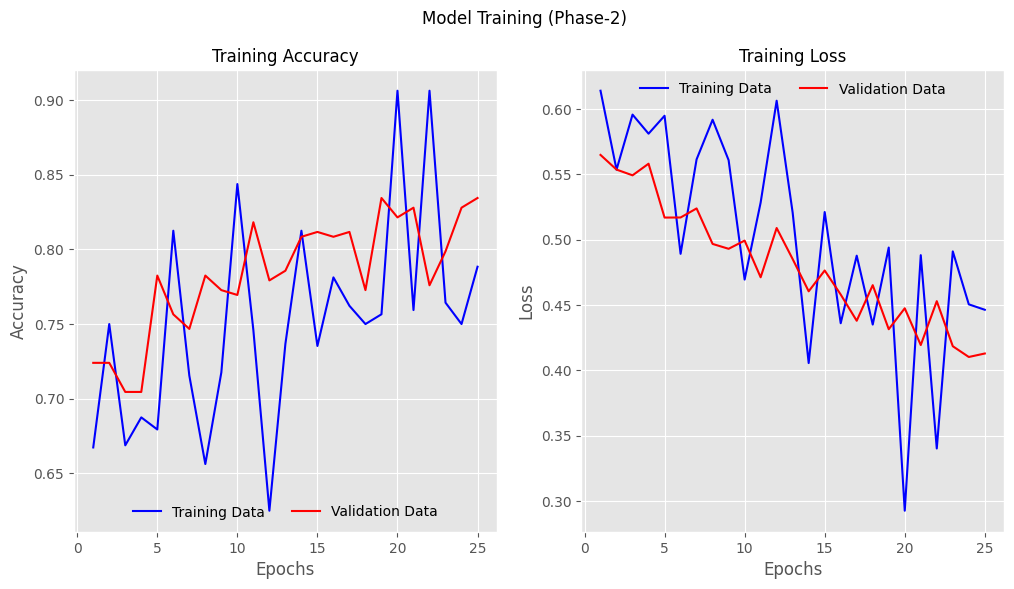

In [ ]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Phase-2)", fontsize=12)
max_epoch = len(history_02.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [ ]:
model_02.load_weights("model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_98']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.7408 - loss: 0.5267
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - accuracy: 0.7297 - loss: 0.5529


# Unfreezing the entire network

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
model_03.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_03 = model_03.fit(train_generator, steps_per_epoch=45, epochs = 35, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.8790 - loss: 0.2984
Epoch 1: val_loss improved from 0.27304 to 0.19121, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8793 - loss: 0.2977 - val_accuracy: 0.9318 - val_loss: 0.1912 - learning_rate: 1.0000e-04
Epoch 2/35


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


 1/45 ━━━━━━━━━━━━━━━━━━━━ 28s 651ms/step - accuracy: 0.8750 - loss: 0.2130

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.19121
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.8750 - loss: 0.2130 - val_accuracy: 0.8864 - val_loss: 0.2536 - learning_rate: 1.0000e-04
Epoch 3/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9116 - loss: 0.2242
Epoch 3: val_loss did not improve from 0.19121
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 819ms/step - accuracy: 0.9113 - loss: 0.2249 - val_accuracy: 0.8994 - val_loss: 0.2575 - learning_rate: 1.0000e-04
Epoch 4/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 27s 616ms/step - accuracy: 0.9062 - loss: 0.2981
Epoch 4: val_loss did not improve from 0.19121
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9062 - loss: 0.2981 - val_accuracy: 0.9091 - val_loss: 0.2116 - learning_rate: 1.0000e-04
Epoch 5/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9156 - loss: 0.2150
Epoch 5: val_loss improved from 0.19121 to 0.16547, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9154 - loss: 0.2151 - val_accuracy: 0.9156 - val_loss: 0.1655 - learning_rate: 1.0000e-04
Epoch 6/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 29s 680ms/step - accuracy: 0.8750 - loss: 0.3126
Epoch 6: val_loss did not improve from 0.16547
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8750 - loss: 0.3126 - val_accuracy: 0.9351 - val_loss: 0.1724 - learning_rate: 1.0000e-04
Epoch 7/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.9203 - loss: 0.2031
Epoch 7: val_loss improved from 0.16547 to 0.16333, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9203 - loss: 0.2032 - val_accuracy: 0.9416 - val_loss: 0.1633 - learning_rate: 1.0000e-04
Epoch 8/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 28s 648ms/step - accuracy: 0.9062 - loss: 0.1784
Epoch 8: val_loss did not improve from 0.16333
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9062 - loss: 0.1784 - val_accuracy: 0.9318 - val_loss: 0.1893 - learning_rate: 1.0000e-04
Epoch 9/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9096 - loss: 0.2160
Epoch 9: val_loss did not improve from 0.16333
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 826ms/step - accuracy: 0.9099 - loss: 0.2158 - val_accuracy: 0.9351 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 10/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 27s 618ms/step - accuracy: 1.0000 - loss: 0.0724
Epoch 10: val_loss did not improve from 0.16333
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 0.0724 - val_accuracy: 0.8604 - val_loss: 0.2857 - learning_rate: 1.0000e-04
Epoch 11/35
45/45 

45/45 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9403 - loss: 0.1502 - val_accuracy: 0.9416 - val_loss: 0.1411 - learning_rate: 1.0000e-04
Epoch 12/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 28s 646ms/step - accuracy: 1.0000 - loss: 0.1027
Epoch 12: val_loss did not improve from 0.14107
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 1.0000 - loss: 0.1027 - val_accuracy: 0.9383 - val_loss: 0.1608 - learning_rate: 1.0000e-04
Epoch 13/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9366 - loss: 0.1562
Epoch 13: val_loss improved from 0.14107 to 0.12674, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9365 - loss: 0.1563 - val_accuracy: 0.9545 - val_loss: 0.1267 - learning_rate: 1.0000e-04
Epoch 14/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 28s 652ms/step - accuracy: 0.9062 - loss: 0.1962
Epoch 14: val_loss did not improve from 0.12674
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9062 - loss: 0.1962 - val_accuracy: 0.9286 - val_loss: 0.1861 - learning_rate: 1.0000e-04
Epoch 15/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.9543 - loss: 0.1365
Epoch 15: val_loss did not improve from 0.12674
45/45 ━━━━━━━━━━━━━━━━━━━━ 68s 823ms/step - accuracy: 0.9541 - loss: 0.1369 - val_accuracy: 0.9026 - val_loss: 0.2557 - learning_rate: 1.0000e-04
Epoch 16/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 27s 619ms/step - accuracy: 0.9062 - loss: 0.2760
Epoch 16: val_loss did not improve from 0.12674
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9062 - loss: 0.2760 - val_accuracy: 0.9416 - val_loss: 0.1547 - learning_rate: 1.0000e-04
Epoch 17/35
45

45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9460 - loss: 0.1446 - val_accuracy: 0.9643 - val_loss: 0.1107 - learning_rate: 1.0000e-04
Epoch 18/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 29s 667ms/step - accuracy: 0.9375 - loss: 0.2091
Epoch 18: val_loss improved from 0.11074 to 0.08713, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 496ms/step - accuracy: 0.9375 - loss: 0.2091 - val_accuracy: 0.9740 - val_loss: 0.0871 - learning_rate: 1.0000e-04
Epoch 19/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9481 - loss: 0.1368
Epoch 19: val_loss improved from 0.08713 to 0.08337, saving model to model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9482 - loss: 0.1368 - val_accuracy: 0.9773 - val_loss: 0.0834 - learning_rate: 1.0000e-04
Epoch 20/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 29s 675ms/step - accuracy: 1.0000 - loss: 0.0673
Epoch 20: val_loss did not improve from 0.08337
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 1.0000 - loss: 0.0673 - val_accuracy: 0.9610 - val_loss: 0.1078 - learning_rate: 1.0000e-04
Epoch 21/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9675 - loss: 0.0947
Epoch 21: val_loss did not improve from 0.08337
45/45 ━━━━━━━━━━━━━━━━━━━━ 61s 815ms/step - accuracy: 0.9672 - loss: 0.0951 - val_accuracy: 0.9708 - val_loss: 0.0876 - learning_rate: 1.0000e-04
Epoch 22/35
 1/45 ━━━━━━━━━━━━━━━━━━━━ 27s 617ms/step - accuracy: 0.9375 - loss: 0.0850
Epoch 22: val_loss did not improve from 0.08337
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9375 - loss: 0.0850 - val_accuracy: 0.9610 - val_loss: 0.1144 - learning_rate: 1.0000e-04
Epoch 23/35
45

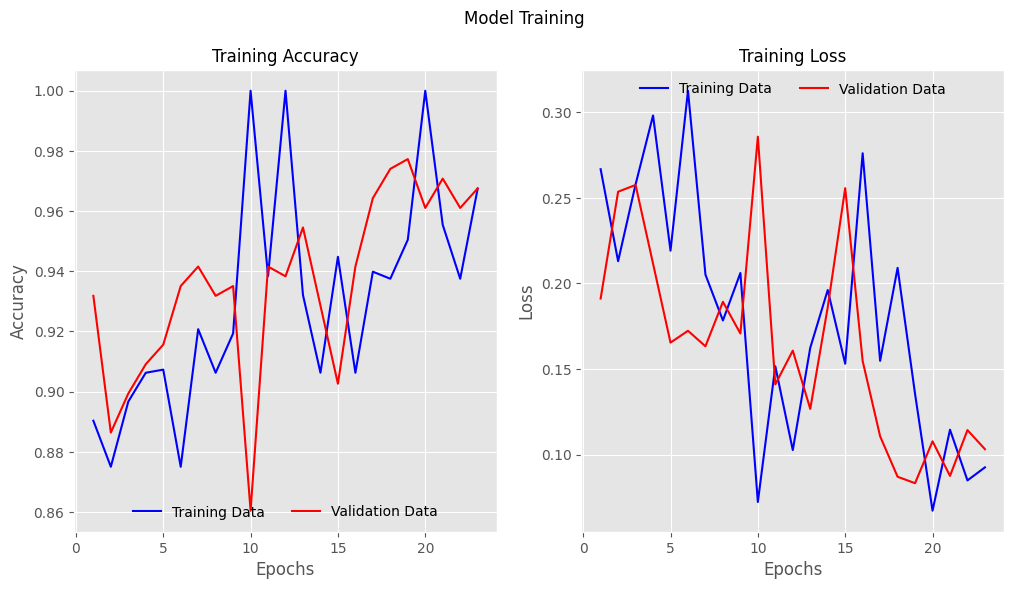

In [ ]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training", fontsize=12)
max_epoch = len(history_03.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_03.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_03.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_03.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_03.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [116]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save(filepath="model_weights/vgg19_ML_Model.h5", overwrite=True)

In [117]:
from tensorflow.keras.models import load_model # Import the load_model function

model_03 = load_model("model_weights/vgg19_ML_Model.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 525ms/step - accuracy: 0.9525 - loss: 0.1449
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - accuracy: 0.9898 - loss: 0.0401


DONE

In [118]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# 1. Load the trained model
model = load_model("model_weights/vgg19_ML_Model.h5") # Add the correct path here


# 2. Set path to test data
test_dir = "tumorous_and_nontumorous/test"  # Replace with your actual path

# 3. Define test data generator (same preprocessing as training)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 4. Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 5. Generate detailed metrics
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# 6. Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# 7. Confusion matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))


Found 310 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.9898 - loss: 0.0401
Test Loss: 0.0339
Test Accuracy: 99.03%
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step

Classification Report:

              precision    recall  f1-score   support

 nontumorous       0.99      0.99      0.99       147
    tumorous       0.99      0.99      0.99       163

    accuracy                           0.99       310
   macro avg       0.99      0.99      0.99       310
weighted avg       0.99      0.99      0.99       310


Confusion Matrix:

[[145   2]
 [  1 162]]


In [119]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# 1. Load the trained model
model = load_model("model_weights/vgg19_ML_Model.h5") # Add the correct path here


# 2. Set path to test data
test_dir = "tumorous_and_nontumorous/train"  # Replace with your actual path

# 3. Define test data generator (same preprocessing as training)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 4. Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 5. Generate detailed metrics
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# 6. Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# 7. Confusion matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))


Found 1445 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.9909 - loss: 0.0524
Test Loss: 0.0304
Test Accuracy: 99.45%
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step

Classification Report:

              precision    recall  f1-score   support

 nontumorous       1.00      0.99      0.99       686
    tumorous       0.99      1.00      0.99       759

    accuracy                           0.99      1445
   macro avg       0.99      0.99      0.99      1445
weighted avg       0.99      0.99      0.99      1445


Confusion Matrix:

[[681   5]
 [  3 756]]


In [120]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# 1. Load the trained model
model = load_model("model_weights/vgg19_ML_Model.h5") # Add the correct path here


# 2. Set path to test data
test_dir = "tumorous_and_nontumorous/valid"  # Replace with your actual path

# 3. Define test data generator (same preprocessing as training)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 4. Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 5. Generate detailed metrics
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# 6. Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# 7. Confusion matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))


Found 308 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.9908 - loss: 0.0372
Test Loss: 0.0260
Test Accuracy: 99.35%
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step

Classification Report:

              precision    recall  f1-score   support

 nontumorous       1.00      0.99      0.99       146
    tumorous       0.99      1.00      0.99       162

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308


Confusion Matrix:

[[144   2]
 [  0 162]]


In [122]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# 1. Load the trained model
model = load_model("model_weights/vgg19_ML_Model.h5") # Add the correct path here


# 2. Set path to test data
test_dir = "augmented_data"  # Replace with your actual path

# 3. Define test data generator (same preprocessing as training)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# 4. Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 5. Generate detailed metrics
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# 6. Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

# 7. Confusion matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))


Found 2064 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - accuracy: 0.9905 - loss: 0.0497
Test Loss: 0.0303
Test Accuracy: 99.37%
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step

Classification Report:

              precision    recall  f1-score   support

          no       1.00      0.99      0.99       980
         yes       0.99      1.00      0.99      1084

    accuracy                           0.99      2064
   macro avg       0.99      0.99      0.99      2064
weighted avg       0.99      0.99      0.99      2064


Confusion Matrix:

[[ 971    9]
 [   4 1080]]
